# Panic Project (DHLAB) - Data Analysis

author:  `@cyshin971`  

date:    `2025-06-20`  

version: `2.0`

> version `1.1`: preprocessing separated to `data_preprocessing.ipynb` (version `1.0`)  
> version `2.0`: Updated to consensus on progress meeting `20250619`

In [1]:
version = '2-0'

# 📚 | Import Libraries 

In [2]:
import config as cfg
import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)

from library.pandas_utils import move_column, aggregate_by_column, create_empty_df, read_csv
from library.text_utils import save_as_csv
from library.json_utils import save_dict_to_file, load_dict_from_file
from library.path_utils import get_file_path

# ⚙️ | Settings

In [3]:
manual_scraped_data_filename = None # Keep as None if you don't want to manually specify a file

# 📁 | Path Variables 

In [4]:
DATA_PATH = "./_data"
TMP_PATH = "./cys/_tmp"
OUT_PATH = "./cys/_output"

try:
	features_dict = load_dict_from_file(OUT_PATH, 'panic_features_dict')
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {get_file_path(OUT_PATH, 'panic_features_dict')}. Please run data_analysis.ipynb first.")
print(f"Loaded features dict with {len(features_dict)} keys:")
scraped_data_filename = None
for k, v in features_dict.items():
    if k == 'scraped_data_filename':
        print(f"  {k}: {v}.csv")
        scraped_data_filename = v
    elif k == 'preproc_version':
        preproc_version = v
    else:
        print(f"  {k}: {v}")

if scraped_data_filename is None:
	raise ValueError("scraped_data_filename not found in features_dict")
if manual_scraped_data_filename is not None:
    logging.warning(f"Using manually specified scraped_data_filename: {manual_scraped_data_filename}. If this is not intended, please set it to None.")
    scraped_data_filename = manual_scraped_data_filename

features_dict['analysis_version'] = version
save_dict_to_file(features_dict, OUT_PATH, 'panic_features_dict')

PREPROC_PATH = f"{OUT_PATH}/{scraped_data_filename}/preprocessed"
OUTPUT_PATH = f"{OUT_PATH}/{scraped_data_filename}/analysis"

DEBUG - (json_utils.py) load_dict_from_file: Dictionary loaded successfully from C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\panic_features_dict.json
DEBUG - (json_utils.py) save_dict_to_file: Dictionary saved successfully to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\panic_features_dict.json


Loaded features dict with 10 keys:
  scraped_data_filename: final_result_20250620_360.csv
  demography: ['gender', 'age', 'marriage', 'job', 'smkHx', 'drinkHx', 'suicideHx', 'suicide_need']
  dailylog: ['severity', 'exercise', 'alcohol', 'coffee', 'menstruation', 'smoking', 'positive_feeling', 'negative_feeling', 'positive_E', 'negative_E', 'anxiety', 'annoying']
  lifelog: ['HR_var', 'HR_max', 'HR_mean', 'HR_hvar_mean', 'HR_acrophase', 'HR_amplitude', 'HR_mesor', 'HR_acrophase_difference', 'HR_acrophase_difference_2d', 'HR_amplitude_difference', 'HR_amplitude_difference_2d', 'HR_mesor_difference', 'HR_mesor_difference_2d', 'bandpower(0.001-0.0005Hz)', 'bandpower(0.0005-0.0001Hz)', 'bandpower(0.0001-0.00005Hz)', 'bandpower(0.00005-0.00001Hz)', 'steps', 'SLT1', 'SLT2', 'SLT3', 'SLT4', 'SLT5', 'SLT6', 'total_sleep', 'steps_maximum', 'steps_mean', 'step_hvar_mean', 'step_delta', 'step_max_delta', 'step_mean_delta', 'step_hvar_mean_delta', 'step_delta2', 'step_max_delta2', 'step_mean_delta

# ⚒️ | Preprocessed Data

## Load Preprocessed Data

In [5]:
pre_data = read_csv(get_file_path(PREPROC_PATH, f'panic_pre_data_{preproc_version}({scraped_data_filename}).csv'))
display(pre_data.head(5))
metadata = read_csv(get_file_path(PREPROC_PATH, f'panic_metadata_{preproc_version}({scraped_data_filename}).csv'))
display(metadata.head(5))
demography_data = read_csv(get_file_path(PREPROC_PATH, f'panic_demography_data_{preproc_version}({scraped_data_filename}).csv'))
display(demography_data.head(5))

,entry_id,dataset,ID,date,PHQ_9,STAI_X2,CSM,CTQ_1,CTQ_2,CTQ_3,...,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,dbp,panic,severity,panic_label
0,PXPN_10006_2024-11-04,PXPN,PXPN_10006,2024-11-04,0.0,32.0,31.0,11.0,13.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,PXPN_10006_2024-11-05,PXPN,PXPN_10006,2024-11-05,0.0,32.0,31.0,11.0,13.0,17.0,...,4.47,3.62,4.67,0.65,1.85,15.26,NaN,0.0,NaN,0
2,PXPN_10006_2024-11-06,PXPN,PXPN_10006,2024-11-06,0.0,32.0,31.0,11.0,13.0,17.0,...,0.00,0.20,4.07,1.43,1.68,7.38,1.0,1.0,NaN,0
3,PXPN_10006_2024-11-07,PXPN,PXPN_10006,2024-11-07,0.0,32.0,31.0,11.0,13.0,17.0,...,0.00,0.14,5.08,0.00,0.97,6.19,0.0,2.0,1.0,1
4,PXPN_10006_2024-11-08,PXPN,PXPN_10006,2024-11-08,0.0,32.0,31.0,11.0,13.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,panic,n_prior_data,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
0,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,0,1,0,1,NaN,0.0,2,0,1,1,NaN,0,NaN
1,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,0,1,0,1,NaN,0.0,1,0,0,1,NaN,0,NaN
2,SYM2-1-96_2021-08-02,SYM2-1-96,2021-08-02,SYM2,0,1,0,1,NaN,0.0,0,0,0,0,NaN,0,NaN
3,SYM2-1-96_2021-07-30,SYM2-1-96,2021-07-30,SYM2,0,1,0,1,NaN,0.0,2,0,1,1,NaN,0,NaN
4,SYM2-1-96_2021-07-29,SYM2-1-96,2021-07-29,SYM2,0,1,0,1,NaN,0.0,1,0,0,1,NaN,0,NaN


,ID,gender,age,marriage,job,smkHx,drinkHx,suicideHx,suicide_need
0,PXPN_10006,0,32.0,0.0,1.0,1.0,1.0,0.0,0.0
1,PXPN_10007,1,38.0,1.0,1.0,0.0,0.0,0.0,0.0
2,PXPN_10008,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
3,PXPN_10009,1,28.0,0.0,0.0,1.0,0.0,1.0,0.0
4,PXPN_10010,1,21.0,0.0,0.0,1.0,1.0,0.0,0.0


# 🔍 | Data Analysis

## 🕳️ | Null Value Analysis

Produces csv file of the percentage of the null values for each feature in Daily Log, and Life Log

In [6]:
null_value_analysis = create_empty_df()
null_value_analysis = pre_data[features_dict['lifelog']+features_dict['dailylog']].isnull().sum().reset_index()
null_value_analysis.rename(columns={0: 'null_count'}, inplace=True)
null_value_analysis.rename(columns={'index': 'feature'}, inplace=True)

# add a column for the data group using the feqtures_dict
null_value_analysis['data_group'] = null_value_analysis['feature'].apply(
    lambda x: 'lifelog' if x in features_dict['lifelog'] else
			  'dailylog' if x in features_dict['dailylog'] else
			  'other'
)

# add column for total count
null_value_analysis['total_count'] = len(pre_data)
# find the existing percentage
null_value_analysis['exist%'] = (1 - (null_value_analysis['null_count'] / null_value_analysis['total_count'])) * 100

move_column(null_value_analysis, 'data_group', 1)
move_column(null_value_analysis, 'exist%', 2)

save_as_csv(null_value_analysis, OUTPUT_PATH, f"panic_null_value_analysis_{version}({scraped_data_filename})")

display(null_value_analysis.head(5))

DEBUG - (path_utils.py) make_dir: Created directory: C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\final_result_20250620_360\analysis
DEBUG - (text_utils.py) save_as_csv: Saved panic_null_value_analysis_2-0(final_result_20250620_360).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\final_result_20250620_360\analysis


,feature,data_group,exist%,null_count,total_count
0,HR_var,lifelog,44.03,13337,23828
1,HR_max,lifelog,44.03,13337,23828
2,HR_mean,lifelog,44.03,13337,23828
3,HR_hvar_mean,lifelog,44.03,13337,23828
4,HR_acrophase,lifelog,39.32,14460,23828


## 🤯 | Patient-level Analysis

**Description**
- `n_entries`: Number of entries per patient
- `n_valid_3_entries`: Number of valid (3 prior consecutive days of data) entries per patient
- `n_valid_2_entries`: Number of valid (2 prior consecutive days of data) entries per patient
- `n_valid_1_entries`: Number of valid (1 prior consecutive days of data) entries per patient
- `n_panic`: Number of panic events per patient
- `max_severity`: Maximum panic severity experienced by patient
- `min_severity`: Minimum panic severity experienced by patient
- `mean_severity`: Average panic severity experienced by patient
- `n_dailylog`: Number of daily log entries per patient
- `n_lifelog`: Number of life log entries per patient
- `n_questionnaire`: Number of questionnaire entries per patient
- `sum_dtype`: Number of data (by group) per patient
- `mean_dtype`: Average number of data types per entry per patient

In [7]:
agg_matrix = [
	('n_entries', 'entry_id', 'count'),
	('n_valid_3_entries', 'valid_entry_3', 'sum'),
	('n_valid_2_entries', 'valid_entry_2', 'sum'),
	('n_valid_1_entries', 'valid_entry_1', 'sum'),
	('n_panic', 'panic_label', 'sum'),
    ('max_severity', 'severity', 'max'),
	('min_severity', 'severity', 'min'),
	('mean_severity', 'severity', 'mean'),
	('n_dailylog', 'dailylog_data', 'sum'),
	('n_lifelog', 'lifelog_data', 'sum'),
	('n_questionnaire', 'questionnaire_data', 'sum'),
	('sum_dtype', 'dtype_n', 'sum'),
	('mean_dtype', 'dtype_n', 'mean'),
    # ('n_diary', 'diary_data', 'sum'),
]
patient_analysis_data = create_empty_df()
patient_analysis_data = aggregate_by_column(metadata, 'ID', agg_matrix)

display(patient_analysis_data.head(5))
save_as_csv(patient_analysis_data, OUTPUT_PATH, f"panic_patient_analysis_{version}({scraped_data_filename})")

,ID,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype
0,PXPN_10006,29,18,21,25,3,2.0,1.0,1.33,22,28,29,79,2.72
1,PXPN_10007,29,16,20,24,4,2.0,1.0,1.25,20,28,29,77,2.66
2,PXPN_10008,29,18,21,25,3,2.0,1.0,1.67,20,27,29,76,2.62
3,PXPN_10009,29,18,20,23,5,4.0,1.0,2.60,28,28,29,85,2.93
4,PXPN_10010,29,26,27,28,0,NaN,NaN,NaN,23,28,29,80,2.76


DEBUG - (text_utils.py) save_as_csv: Saved panic_patient_analysis_2-0(final_result_20250620_360).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\final_result_20250620_360\analysis


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/final_result_20250620_360/analysis/panic_patient_analysis_2-0(final_result_20250620_360).csv')

## 🤯🕳️ | Patient-level Existing Value Analysis

Produces csv file of the percentage of the existing values for each feature in Daily Log, and Life Log for each patient

In [8]:
agg_matrix = [('n_entries', 'entry_id', 'count')]

for col in features_dict['lifelog'] + features_dict['dailylog']:
    agg_matrix.append((col, col, 'count'))

patient_null_analysis_data = create_empty_df()
patient_null_analysis_data = aggregate_by_column(pre_data, 'ID', agg_matrix)

for col in features_dict['lifelog'] + features_dict['dailylog']:
    patient_null_analysis_data[col] = patient_null_analysis_data[col] / patient_null_analysis_data['n_entries'] * 100

patient_null_analysis_data['lifelog_avg'] = patient_null_analysis_data[features_dict['lifelog']].mean(axis=1)
patient_null_analysis_data['dailylog_avg'] = patient_null_analysis_data[features_dict['dailylog']].mean(axis=1)
patient_null_analysis_data['total_avg'] = patient_null_analysis_data[features_dict['lifelog'] + features_dict['dailylog']].mean(axis=1)

display(patient_null_analysis_data.head(5))
save_as_csv(patient_null_analysis_data, OUTPUT_PATH, f"panic_patient_existval_analysis_{version}({scraped_data_filename})")

,ID,n_entries,HR_var,HR_max,HR_mean,HR_hvar_mean,HR_acrophase,HR_amplitude,HR_mesor,HR_acrophase_difference,...,smoking,positive_feeling,negative_feeling,positive_E,negative_E,anxiety,annoying,lifelog_avg,dailylog_avg,total_avg
0,PXPN_10006,29,86.21,86.21,86.21,86.21,31.03,31.03,31.03,10.34,...,0.00,68.97,68.97,65.52,65.52,75.86,75.86,61.79,39.66,56.37
1,PXPN_10007,29,96.55,96.55,96.55,96.55,44.83,44.83,44.83,17.24,...,0.00,34.48,34.48,55.17,55.17,68.97,68.97,54.80,34.48,49.82
2,PXPN_10008,29,93.10,93.10,93.10,93.10,41.38,41.38,41.38,20.69,...,0.00,55.17,55.17,51.72,51.72,68.97,68.97,52.00,32.76,47.29
3,PXPN_10009,29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,37.93,96.55,96.55,96.55,96.55,96.55,96.55,31.31,58.62,38.00
4,PXPN_10010,29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,72.41,75.86,75.86,75.86,75.86,79.31,79.31,32.34,52.59,37.30


DEBUG - (text_utils.py) save_as_csv: Saved panic_patient_existval_analysis_2-0(final_result_20250620_360).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\final_result_20250620_360\analysis


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/final_result_20250620_360/analysis/panic_patient_existval_analysis_2-0(final_result_20250620_360).csv')

# 📒 | Reports

In [9]:
from library.matplotlib_utils import plot_histogram_of_counts

## Overview

In [10]:
unique_ids =  pre_data['ID'].unique()
print(f"Total number of unique IDs in pre_data_filled: {len(unique_ids)}")
print(f"Total number of entries in pre_data_filled: {len(pre_data)}")
panic_entries = pre_data[pre_data['panic_label'] == 1]
print(f"Total number of panic entries in pre_data_filled: {len(panic_entries)}")

Total number of unique IDs in pre_data_filled: 273
Total number of entries in pre_data_filled: 23828
Total number of panic entries in pre_data_filled: 811


In [11]:
filled_entry_ids = pre_data['entry_id'].unique()
print(f"Total number of daily log entries: {metadata[metadata['dailylog_data'] == 1].shape[0]} / {len(filled_entry_ids)} ({metadata[metadata['dailylog_data'] == 1].shape[0] / len(filled_entry_ids) * 100:.2f}%)")
print(f"Total number of life log entries: {metadata[metadata['lifelog_data'] == 1].shape[0]} / {len(filled_entry_ids)} ({metadata[metadata['lifelog_data'] == 1].shape[0] / len(filled_entry_ids) * 100:.2f}%)")
print(f"Total number of questionnaire entries: {metadata[metadata['questionnaire_data'] == 1].shape[0]} / {len(filled_entry_ids)} ({metadata[metadata['questionnaire_data'] == 1].shape[0] / len(filled_entry_ids) * 100:.2f}%)")
# print(f"Total number of panic diary entries: {metadata[metadata['diary_data'] == 1].shape[0]} / {len(filled_entry_ids)} ({metadata[metadata['diary_data'] == 1].shape[0] / len(filled_entry_ids) * 100:.2f}%)")

Total number of daily log entries: 14854 / 23828 (62.34%)
Total number of life log entries: 12408 / 23828 (52.07%)
Total number of questionnaire entries: 17978 / 23828 (75.45%)


In [12]:
panic_patients = metadata[metadata['panic_label'] == 1]['ID'].unique()
print(f"Total number of patients with panic events: {len(panic_patients)}")

Total number of patients with panic events: 105


## 🗒️ | Entry-level Analysis

### Data Groups

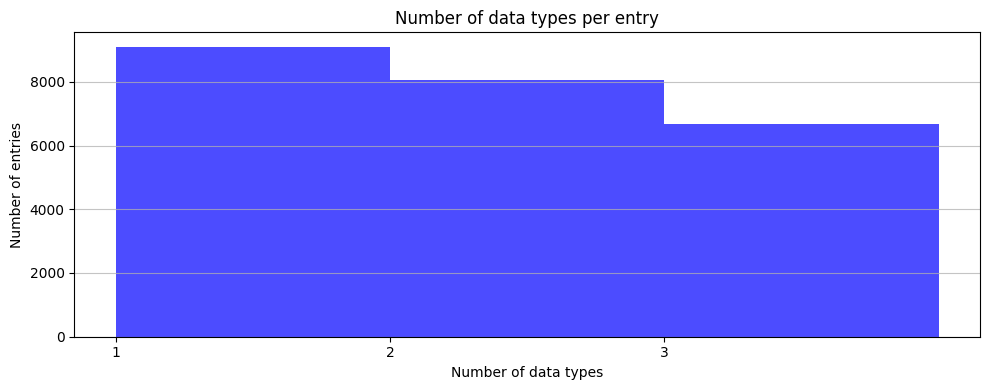

Number of entries with 1 data type: 9098 (38.18%)
Number of entries with 2 data types: 8048 (33.78%)
Number of entries with 3 data types: 6682 (28.04%)


In [13]:
plot_histogram_of_counts(metadata['dtype_n'], title='Number of data types per entry', xlabel='Number of data types', ylabel='Number of entries', zero_start=False, bins_step=1)
print(f"Number of entries with 1 data type: {metadata[metadata['dtype_n'] == 1].shape[0]} ({metadata[metadata['dtype_n'] == 1].shape[0] / metadata.shape[0] * 100:.2f}%)")
print(f"Number of entries with 2 data types: {metadata[metadata['dtype_n'] == 2].shape[0]} ({metadata[metadata['dtype_n'] == 2].shape[0] / metadata.shape[0] * 100:.2f}%)")
print(f"Number of entries with 3 data types: {metadata[metadata['dtype_n'] == 3].shape[0]} ({metadata[metadata['dtype_n'] == 3].shape[0] / metadata.shape[0] * 100:.2f}%)")

### Valid Entries

In [14]:
print(f"Total number of valid entries (3 days): {metadata['valid_entry_3'].sum()} ({metadata['valid_entry_3'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (2 days): {metadata['valid_entry_2'].sum()} ({metadata['valid_entry_2'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (1 day): {metadata['valid_entry_1'].sum()} ({metadata['valid_entry_1'].mean() * 100:.2f}%)")

Total number of valid entries (3 days): 20275 (85.09%)
Total number of valid entries (2 days): 21116 (88.62%)
Total number of valid entries (1 day): 22205 (93.19%)


In [15]:
panic_n = pre_data[pre_data['dbp'] == 0].shape[0]
print(f"Total number of panic events (dbp=0): {panic_n}")
valid_panic_events_3 = metadata[(metadata['valid_entry_3'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 3 days): {valid_panic_events_3} ({valid_panic_events_3 / panic_n * 100:.2f}%)")
valid_panic_events_2 = metadata[(metadata['valid_entry_2'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 2 days): {valid_panic_events_2} ({valid_panic_events_2 / panic_n * 100:.2f}%)")
valid_panic_events_1 = metadata[(metadata['valid_entry_1'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 1 day): {valid_panic_events_1} ({valid_panic_events_1 / panic_n * 100:.2f}%)")

Total number of panic events (dbp=0): 811
Total number of valid panic events (n_prior_data >= 3 days): 319 (39.33%)
Total number of valid panic events (n_prior_data >= 2 days): 381 (46.98%)
Total number of valid panic events (n_prior_data >= 1 day): 502 (61.90%)


In [16]:
one_dbp = metadata[metadata['dbp'] == 1]
print(f"Total number of entries with dbp=1: {one_dbp.shape[0]} ({one_dbp.shape[0] / metadata.shape[0] * 100:.2f}%)")
two_dvp = metadata[metadata['dbp'] == 2]
print(f"Total number of entries with dbp=2: {two_dvp.shape[0]} ({two_dvp.shape[0] / metadata.shape[0] * 100:.2f}%)")

Total number of entries with dbp=1: 502 (2.11%)
Total number of entries with dbp=2: 384 (1.61%)


## 🤢 | Patient-level Analysis

In [17]:
pre_data_ids = pre_data['ID'].unique()

### Patient-level Valid Entries

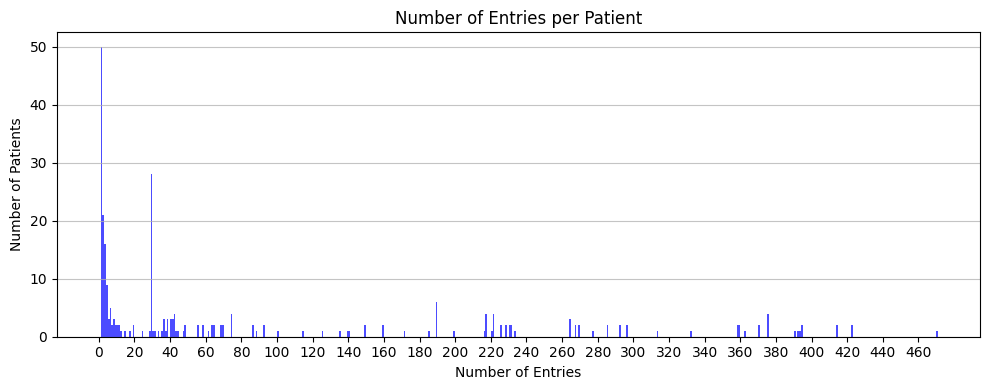

Number of valid patients (1 days): 205 / 273
68 patients do not have valid entries (i.e., no data for at least 1 days before panic event)


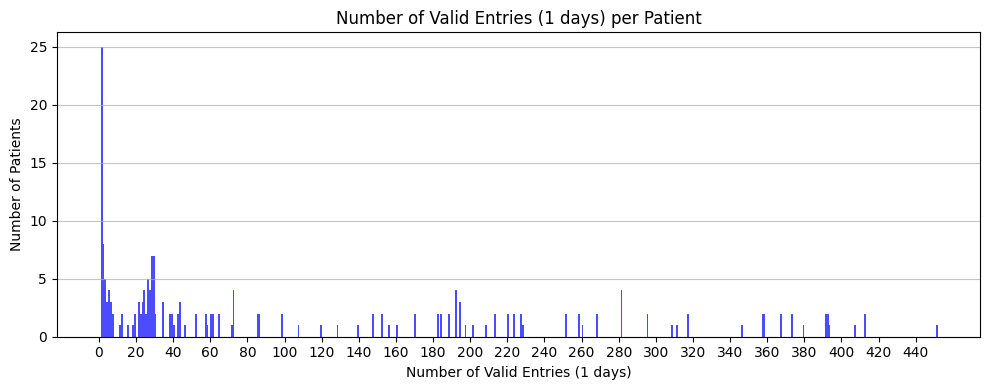

Number of valid patients (2 days): 177 / 273
96 patients do not have valid entries (i.e., no data for at least 2 days before panic event)


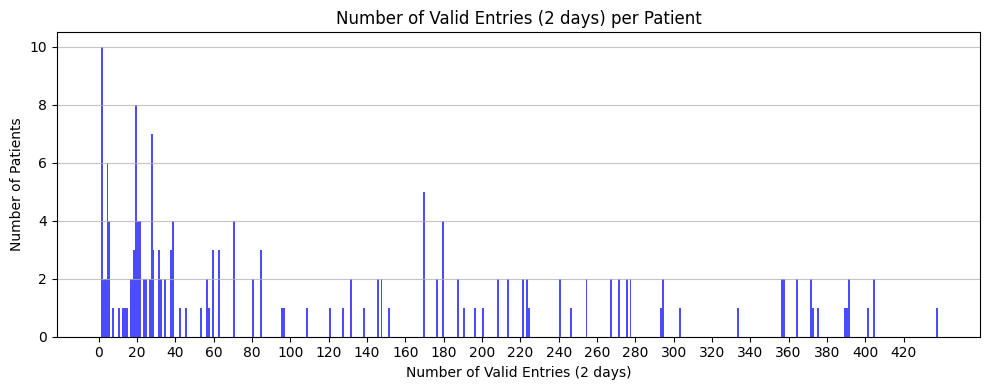

Number of valid patients (3 days): 167 / 273
106 patients do not have valid entries (i.e., no data for at least 3 days before panic event)


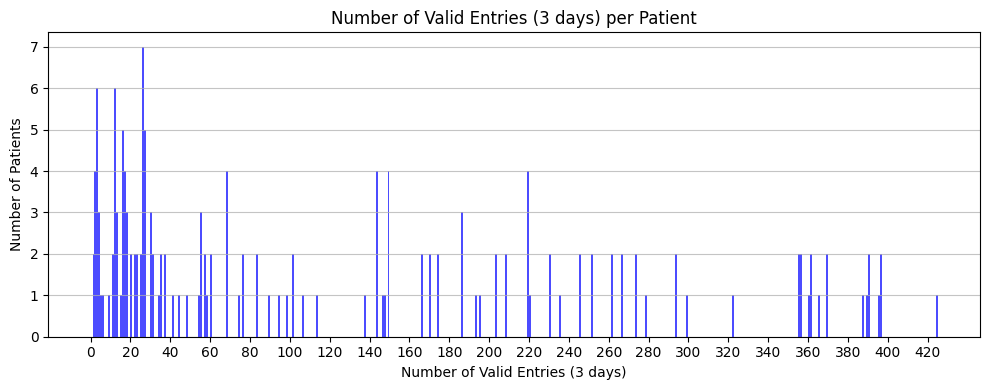

In [18]:
plot_histogram_of_counts(patient_analysis_data['n_entries'], title='Number of Entries per Patient',
                         xlabel='Number of Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_1_entries'] > 0]
n_valid_patients_1 = valid_patients.shape[0]
print(f"Number of valid patients (1 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 1 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_1_entries'], title='Number of Valid Entries (1 days) per Patient',
                         xlabel='Number of Valid Entries (1 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_2_entries'] > 0]
n_valid_patients_2 = valid_patients.shape[0]
print(f"Number of valid patients (2 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 2 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_2_entries'], title='Number of Valid Entries (2 days) per Patient',
                         xlabel='Number of Valid Entries (2 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_3_entries'] > 0]
n_valid_patients_3 = valid_patients.shape[0]
print(f"Number of valid patients (3 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 3 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_3_entries'], title='Number of Valid Entries (3 days) per Patient',
                         xlabel='Number of Valid Entries (3 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
del valid_patients

### Patient-level Panic Analysis

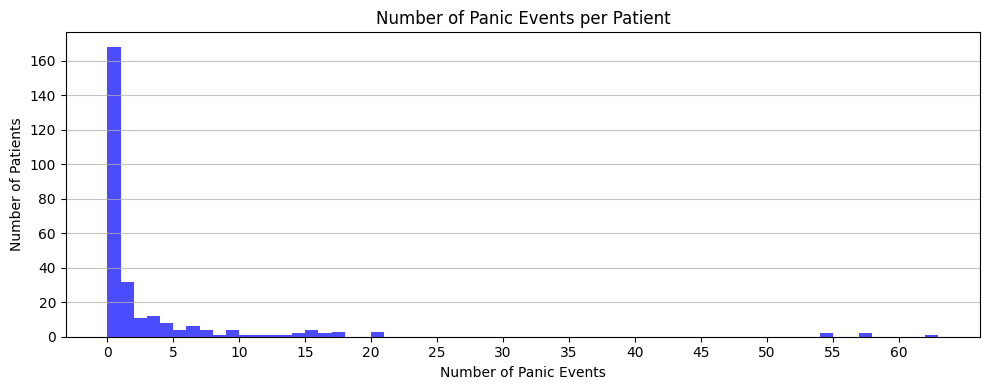

Number of patients with zero panic events: 168 / 273


In [19]:
plot_histogram_of_counts(patient_analysis_data['n_panic'], title='Number of Panic Events per Patient', xlabel='Number of Panic Events', ylabel='Number of Patients', bins_step=5)
print(f"Number of patients with zero panic events: {patient_analysis_data[patient_analysis_data['n_panic'] == 0].shape[0]} / {len(pre_data_ids)}")

In [20]:


valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_3_entries'] > 0)]
print(f"Number of patients with valid panic events (3 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_3}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_2_entries'] > 0)]
print(f"Number of patients with valid panic events (2 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_2}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_1_entries'] > 0)]
print(f"Number of patients with valid panic events (1 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_1}")
del valid_panic_events_patients

Number of patients with valid panic events (3 days): 82 / 167
Number of patients with valid panic events (2 days): 87 / 177
Number of patients with valid panic events (1 days): 94 / 205


In [21]:
patients_with_panic = patient_analysis_data[patient_analysis_data['n_panic'] > 0]
print(f"Number of patients with panic events: {patients_with_panic.shape[0]} / {len(pre_data_ids)}")

Number of patients with panic events: 105 / 273


### Patient-level Data Group Analysis

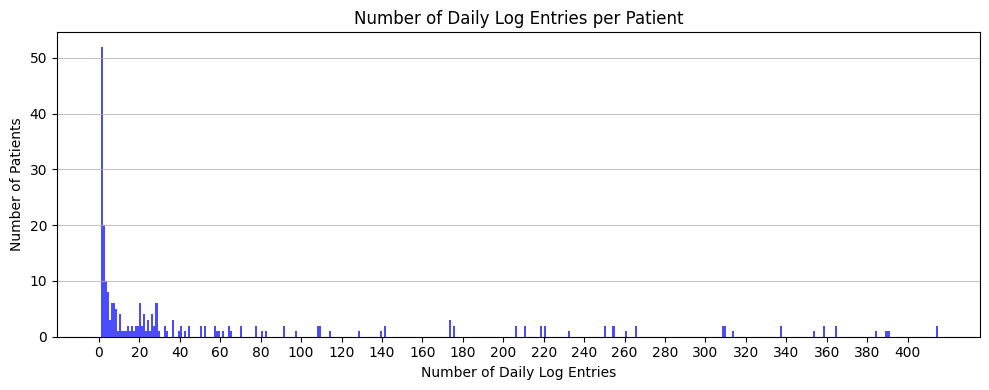

Number of patients with no daily log entries: 35 / 273


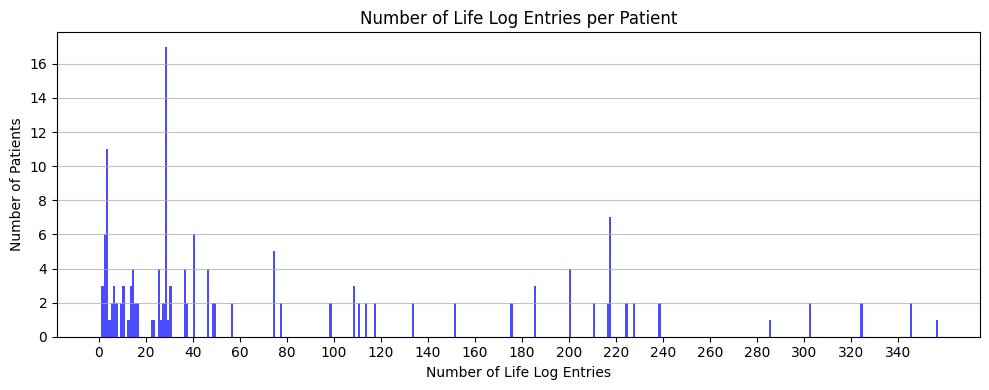

Number of patients with no life log entries: 120 / 273


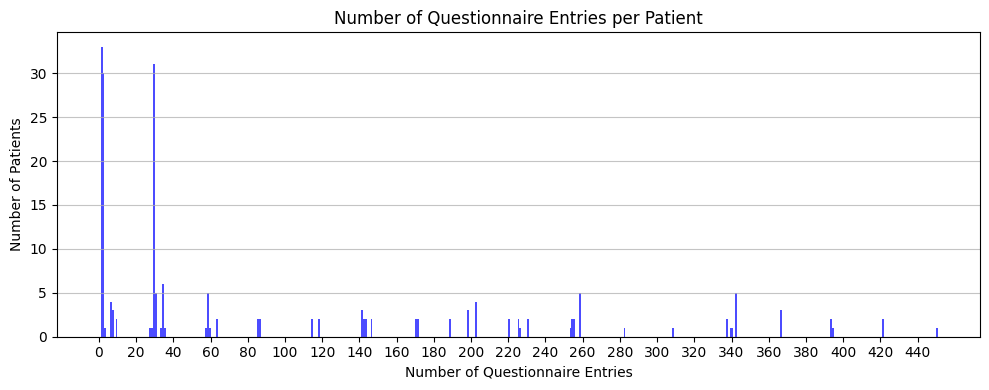

Number of patients with no questionnaire entries: 78 / 273


In [22]:
plot_histogram_of_counts(patient_analysis_data['n_dailylog'], title='Number of Daily Log Entries per Patient',
						 xlabel='Number of Daily Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no daily log entries: {patient_analysis_data[patient_analysis_data['n_dailylog'] == 0].shape[0]} / {len(pre_data_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_lifelog'], title='Number of Life Log Entries per Patient',
						 xlabel='Number of Life Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no life log entries: {patient_analysis_data[patient_analysis_data['n_lifelog'] == 0].shape[0]} / {len(pre_data_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_questionnaire'], title='Number of Questionnaire Entries per Patient',
						 xlabel='Number of Questionnaire Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no questionnaire entries: {patient_analysis_data[patient_analysis_data['n_questionnaire'] == 0].shape[0]} / {len(pre_data_ids)}")
# plot_histogram_of_counts(patient_analysis_data['n_diary'], title='Number of Panic Diary Entries per Patient',
# 						 xlabel='Number of Panic Diary Entries', ylabel='Number of Patients', bins_step=5, exclude_zero=True)
# print(f"Number of patients with no panic diary entries: {patient_analysis_data[patient_analysis_data['n_diary'] == 0].shape[0]} / {len(pre_data_ids)}")

In [23]:
metadata_panic = metadata[metadata['panic_label'] == 1].copy()
print(f"Number of panic events in preprocessed data: {metadata_panic.shape[0]}")
agg_matrix = [
	('valid_entries_3', 'valid_entry_3', 'sum'),
	('valid_entries_2', 'valid_entry_2', 'sum'),
	('valid_entries_1', 'valid_entry_1', 'sum'),
]
agg_metadata_panic = aggregate_by_column(metadata_panic, 'ID', agg_matrix)

print(f"Number of valid panic entries (valid_entry_3): {agg_metadata_panic['valid_entries_3'].sum()}")
print(f"Number of valid panic entries (valid_entry_2): {agg_metadata_panic['valid_entries_2'].sum()}")
print(f"Number of valid panic entries (valid_entry_1): {agg_metadata_panic['valid_entries_1'].sum()}")
print("--------------------------------------------------------")
print(f"Number of patients with valid panic entries (valid_entry_3): {agg_metadata_panic[agg_metadata_panic['valid_entries_3'] > 0].shape[0]}")
print(f"Number of patients with valid panic entries (valid_entry_2): {agg_metadata_panic[agg_metadata_panic['valid_entries_2'] > 0].shape[0]}")
print(f"Number of patients with valid panic entries (valid_entry_1): {agg_metadata_panic[agg_metadata_panic['valid_entries_1'] > 0].shape[0]}")

Number of panic events in preprocessed data: 811
Number of valid panic entries (valid_entry_3): 319
Number of valid panic entries (valid_entry_2): 381
Number of valid panic entries (valid_entry_1): 502
--------------------------------------------------------
Number of patients with valid panic entries (valid_entry_3): 71
Number of patients with valid panic entries (valid_entry_2): 74
Number of patients with valid panic entries (valid_entry_1): 85
